<a href="https://colab.research.google.com/github/RewinaB/Deep-Learning-Projects/blob/main/sourcing_channel_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sourcing Channel Performance Analysis
This notebook simulates a realistic dataset to analyze how sourcing channels influence employee performance across different roles and demographics.

Goal: Identify which sourcing channels (e.g., LinkedIn, Referral, Job Fair) lead to high-performing hires, and how this varies by role and demographics.
* Which sourcing channels are associated with better hires.

* Whether these associations differ across demographics (race, gender) and roles.

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency
warnings.filterwarnings("ignore")

In [14]:
# Load dataset
df = pd.read_csv("/content/simulated_sourcing_data_realistic.csv")
df.head()

,sourcing_channel,performance_class,role,race,gender,years_experience,education_level,cognitive_score,communication_score
0,Referral,Low,Engineer,Asian,Male,5.3,Bachelors,70.550899,57.128857
1,Agency,Low,Manager,Other,Female,5.5,Bachelors,74.904602,74.251291
2,Internal,High,Sales,White,Male,5.7,Bachelors,64.846149,88.314149
3,JobFair,Low,Analyst,Other,Male,4.9,Bachelors,69.532554,66.076401
4,LinkedIn,Low,Support,Asian,Non-Binary,5.3,Masters,57.641176,82.208098


* 1 Descriptive Statistics + Crosstabs + Chi-Square
Analyze the distribution of performance across sourcing channels.

Use a chi-square test to see if performance is statistically dependent on the sourcing channel.

In [15]:
df.groupby(['sourcing_channel', 'role', 'race', 'gender'])['performance_class'].value_counts(normalize=True)


sourcing_channel  role     race   gender      performance_class
Agency            Analyst  Asian  Female      Low                  0.722222
                                              Medium               0.166667
                                              High                 0.111111
                                  Male        Low                  0.600000
                                              Medium               0.400000
                                                                     ...   
Referral          Support  White  Male        High                 0.230769
                                              Medium               0.192308
                                  Non-Binary  Medium               0.448276
                                              Low                  0.379310
                                              High                 0.172414
Name: proportion, Length: 1071, dtype: float64

In [27]:
pd.crosstab(df['sourcing_channel'], df['performance_class'], normalize='index')
chi2_contingency(pd.crosstab(df['sourcing_channel'], df['performance_class']))


Chi2ContingencyResult(statistic=np.float64(191.02700007506294), pvalue=np.float64(4.9518530411121734e-37), dof=8, expected_freq=array([[ 144.918125,  685.89675 ,  346.185125],
       [ 141.470625,  669.57975 ,  337.949625],
       [ 200.4475  ,  948.717   ,  478.8355  ],
       [ 253.514375, 1199.88225 ,  605.603375],
       [ 244.649375, 1157.92425 ,  584.426375]]))

In [16]:
performance_dist = (
    df.groupby(['sourcing_channel', 'role', 'race', 'gender'])['performance_class']
    .value_counts(normalize=True)
    .rename("proportion")
    .reset_index()
)

# Pivot for easier inspection (optional)
pivot = performance_dist.pivot_table(
    index=['sourcing_channel', 'role', 'race', 'gender'],
    columns='performance_class',
    values='proportion',
    fill_value=0
).reset_index()

print (pivot)

performance_class sourcing_channel     role   race      gender      High  \
0                           Agency  Analyst  Asian      Female  0.111111   
1                           Agency  Analyst  Asian        Male  0.000000   
2                           Agency  Analyst  Asian  Non-Binary  0.000000   
3                           Agency  Analyst  Black      Female  0.200000   
4                           Agency  Analyst  Black        Male  0.153846   
..                             ...      ...    ...         ...       ...   
370                       Referral  Support  Other        Male  0.160000   
371                       Referral  Support  Other  Non-Binary  0.142857   
372                       Referral  Support  White      Female  0.275862   
373                       Referral  Support  White        Male  0.230769   
374                       Referral  Support  White  Non-Binary  0.172414   

performance_class       Low    Medium  
0                  0.722222  0.166667  
1      

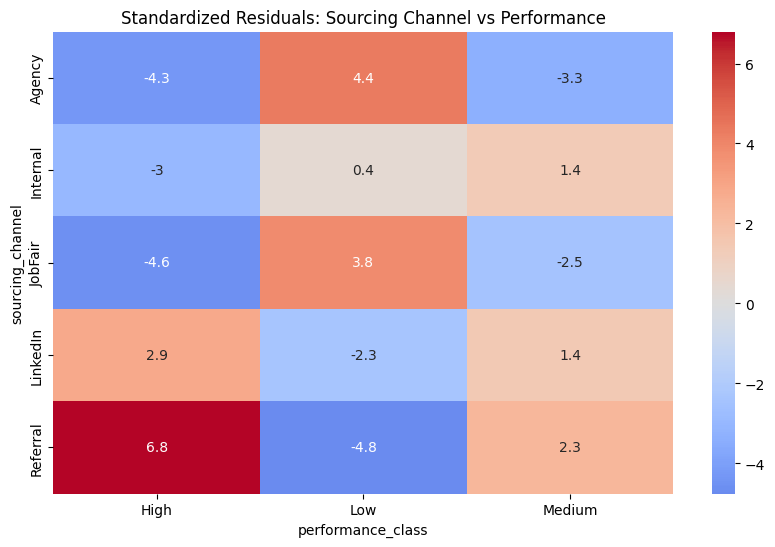

In [28]:
observed = pd.crosstab(df['sourcing_channel'], df['performance_class'])
expected = pd.DataFrame(expected, index=observed.index, columns=observed.columns)

# Residuals
residuals = (observed - expected) / np.sqrt(expected)

# Heatmap of residuals
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.heatmap(residuals, annot=True, cmap='coolwarm', center=0)
plt.title("Standardized Residuals: Sourcing Channel vs Performance")
plt.show()


Chi-square = 191.03 → A large value, meaning the observed distribution is far from what we’d expect under independence.

df = 8 → Degrees of freedom, based on the number of categories:
(#rows - 1) × (#columns - 1)

p-value ≈ 0 → Extremely small → strong evidence against the null hypothesis.

Conclusion:
There is a statistically significant relationship between sourcing channel and performance class. Some channels are more likely to yield high performers than others.

**Logistic Regression**
Use logistic regression with performance as the dependent variable and sourcing channel + race + gender + role as predictors.

Tells you odds of being high performer based on sourcing method, adjusting for demographics.

In [21]:
# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['sourcing_channel', 'role', 'race', 'gender', 'education_level'], drop_first=True)

# Define features and target
X = df_encoded.drop(columns=['performance_class'])
y = df['performance_class']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [29]:
# Step 1: Preview unique values in original categorical columns
print("Unique values before encoding:\n")
print("Sourcing Channel:", df['sourcing_channel'].unique())
print("Role:", df['role'].unique())
print("Race:", df['race'].unique())
print("Gender:", df['gender'].unique())
print("Education Level:", df['education_level'].unique())

# Step 2: One-hot encode with drop_first=True
df_encoded = pd.get_dummies(df, columns=['sourcing_channel', 'role', 'race', 'gender', 'education_level'], drop_first=True)

# Step 3: Show all resulting dummy column names
print("\nDummy Encoded Columns:\n")
print(df_encoded.columns.tolist())



Unique values before encoding:

Sourcing Channel: ['Referral' 'Agency' 'Internal' 'JobFair' 'LinkedIn']
Role: ['Engineer' 'Manager' 'Sales' 'Analyst' 'Support']
Race: ['Asian' 'Other' 'White' 'Latino' 'Black']
Gender: ['Male' 'Female' 'Non-Binary']
Education Level: ['Bachelors' 'Masters' 'PhD']

Dummy Encoded Columns:

['performance_class', 'years_experience', 'cognitive_score', 'communication_score', 'sourcing_channel_Internal', 'sourcing_channel_JobFair', 'sourcing_channel_LinkedIn', 'sourcing_channel_Referral', 'role_Engineer', 'role_Manager', 'role_Sales', 'role_Support', 'race_Black', 'race_Latino', 'race_Other', 'race_White', 'gender_Male', 'gender_Non-Binary', 'education_level_Masters', 'education_level_PhD']


In [23]:
# Train Logistic Regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
High,0.000000,0.000000,0.000000,197.0000
Low,0.582500,1.000000,0.736177,932.0000
Medium,0.000000,0.000000,0.000000,471.0000
accuracy,0.582500,0.582500,0.582500,0.5825
macro avg,0.194167,0.333333,0.245392,1600.0000
weighted avg,0.339306,0.582500,0.428823,1600.0000


In [31]:
log_reg = LogisticRegression(multi_class='multinomial', class_weight='balanced')
X = pd.get_dummies(df[['sourcing_channel', 'role', 'race', 'gender']], drop_first=True)
y = df['performance_class']
log_reg.fit(X, y)
coef_df = pd.DataFrame(log_reg.coef_, columns=X.columns, index=log_reg.classes_)
coef_df.T  # transpose so you can read by feature


,High,Low,Medium
sourcing_channel_Internal,0.052578,-0.231307,0.178729
sourcing_channel_JobFair,0.019593,-0.068306,0.048713
sourcing_channel_LinkedIn,0.389916,-0.433801,0.043885
sourcing_channel_Referral,0.538281,-0.568692,0.030411
role_Engineer,-0.036093,0.070595,-0.034503
role_Manager,0.088135,-0.066283,-0.021852
role_Sales,0.081497,-0.046720,-0.034777
role_Support,0.071976,-0.042377,-0.029599
race_Black,0.018449,0.036928,-0.055378
race_Latino,-0.036056,0.004011,0.032046


| Channel  | High      | Medium    | Low       | Takeaway                                                                         |
| -------- | --------- | --------- | --------- | -------------------------------------------------------------------------------- |
| Internal | **+0.05** | **+0.18** | **–0.23** | Slightly better than average for Medium performers; less likely to produce Low.  |
| JobFair  | +0.02     | +0.05     | –0.07     | Very mild positive association with Medium. Neutral overall.                     |
| LinkedIn | **+0.39** | +0.04     | **–0.43** | Most predictive of High performers; **less likely to result in Low performers.** |
| Referral | **+0.54** | +0.03     | **–0.57** | **Strongest link to High performers**, and least likely to produce Low.
       |


Text(0.5, 1.0, 'Logistic Regression Coefficients by Performance Class')

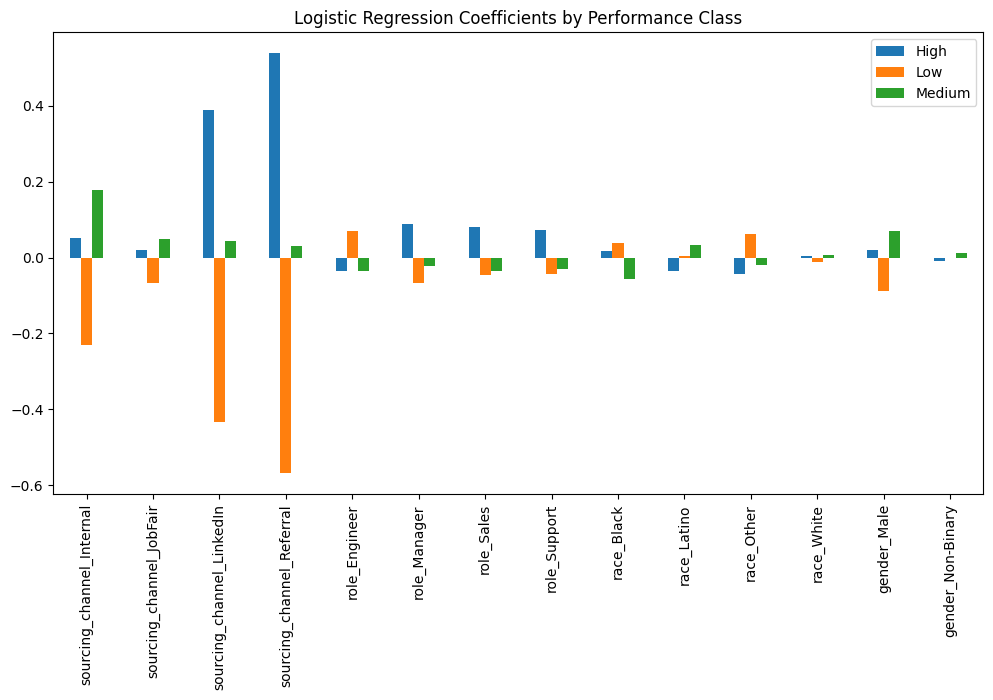

In [32]:
coef_df.T.plot(kind='bar', figsize=(12,6))
plt.title("Logistic Regression Coefficients by Performance Class")


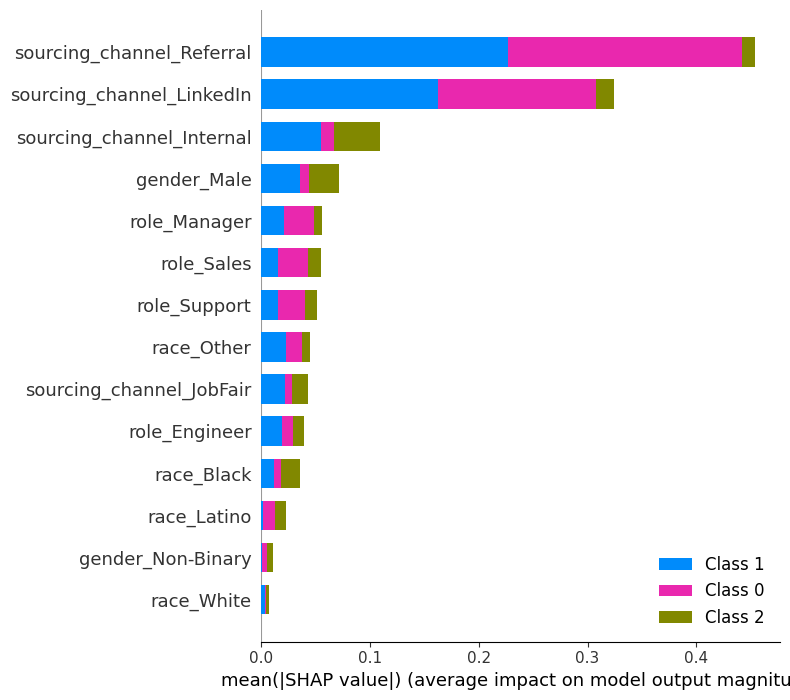

In [33]:
import shap
explainer = shap.Explainer(log_reg, X)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)


In [25]:
# Sourcing channel vs performance by role/gender
grouped = df.groupby(['sourcing_channel', 'role', 'gender'])['performance_class'].value_counts(normalize=True).unstack().fillna(0)
grouped.head()

performance_class                         High       Low    Medium
sourcing_channel role     gender                                  
Agency           Analyst  Female      0.103448  0.712644  0.183908
                          Male        0.053333  0.613333  0.333333
                          Non-Binary  0.129032  0.580645  0.290323
                 Engineer Female      0.112676  0.676056  0.211268
                          Male        0.073529  0.602941  0.323529

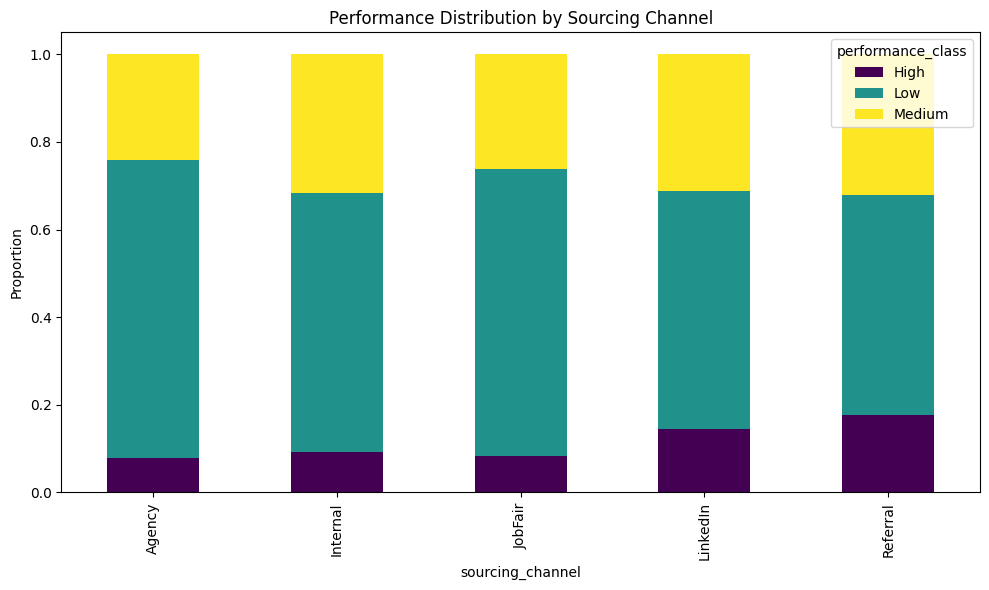

In [34]:
# Plot average performance by sourcing channel
avg_perf_by_channel = df.groupby('sourcing_channel')['performance_class'].value_counts(normalize=True).unstack().fillna(0)
avg_perf_by_channel.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')
plt.title("Performance Distribution by Sourcing Channel")
plt.ylabel("Proportion")
plt.tight_layout()
plt.show()

**By Gender**

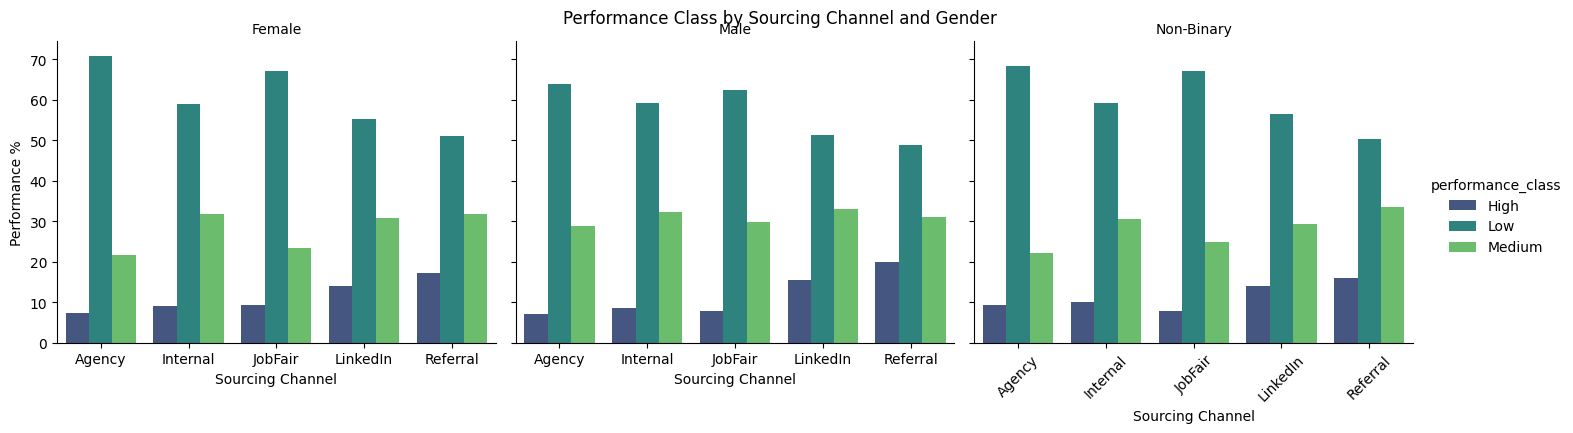

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group and count
gender_grouped = df.groupby(['gender', 'sourcing_channel', 'performance_class']).size().reset_index(name='count')

# Normalize to percent within each gender+sourcing_channel
gender_grouped['percent'] = gender_grouped.groupby(['gender', 'sourcing_channel'])['count'].transform(lambda x: 100 * x / x.sum())

# Plot
g = sns.catplot(
    data=gender_grouped,
    kind="bar",
    x="sourcing_channel", y="percent", hue="performance_class",
    col="gender", col_wrap=3,
    height=4, aspect=1.2,
    palette="viridis"
)

g.set_titles("{col_name}")
g.set_axis_labels("Sourcing Channel", "Performance %")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Performance Class by Sourcing Channel and Gender")
plt.xticks(rotation=45)
plt.show()


**By Race**

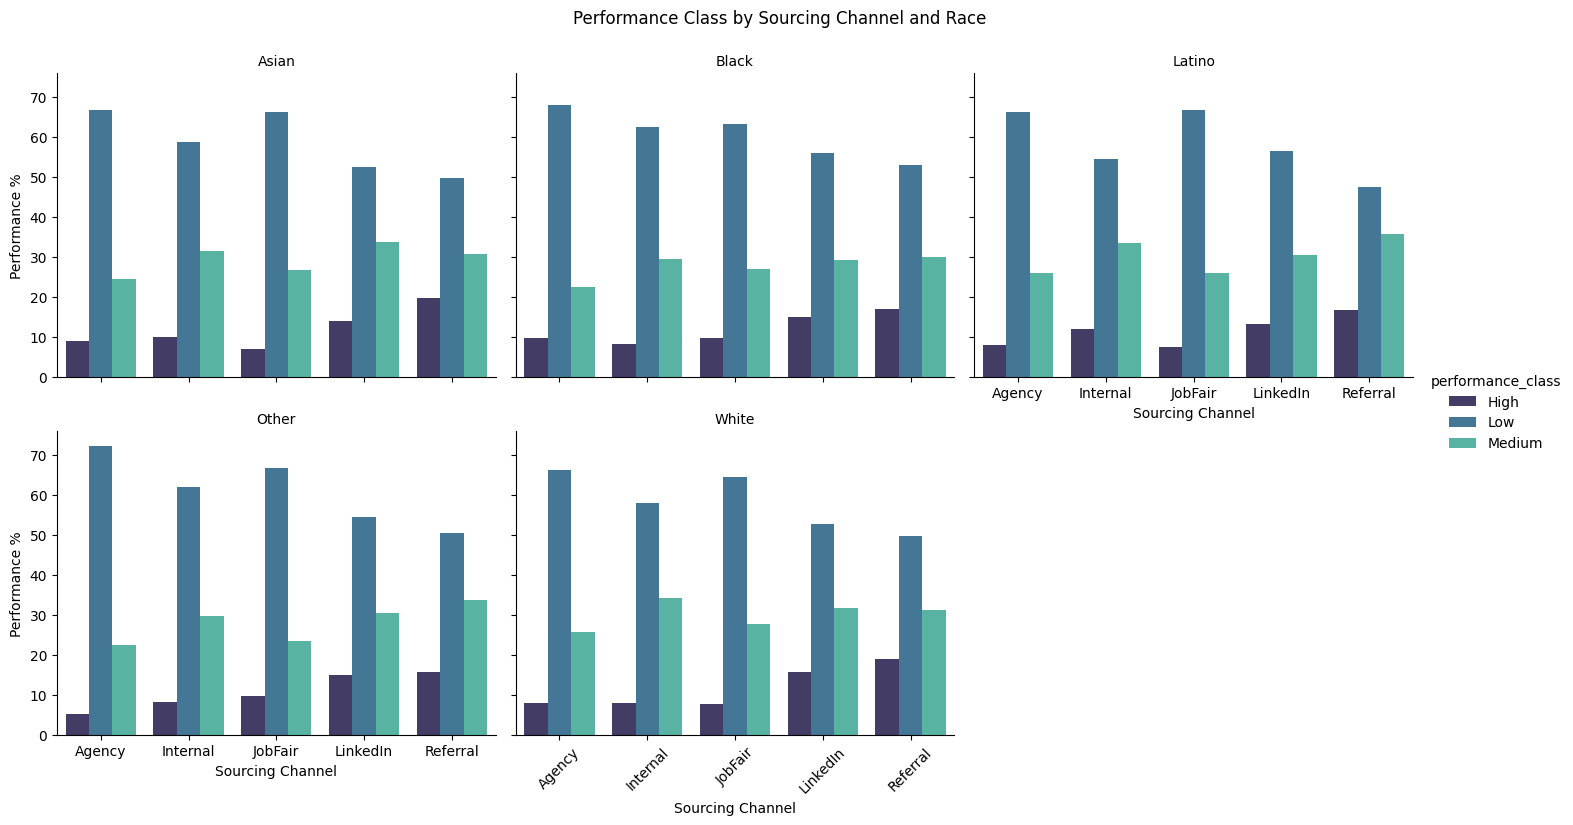

In [37]:
# Group and normalize
race_grouped = df.groupby(['race', 'sourcing_channel', 'performance_class']).size().reset_index(name='count')
race_grouped['percent'] = race_grouped.groupby(['race', 'sourcing_channel'])['count'].transform(lambda x: 100 * x / x.sum())

# Plot
g = sns.catplot(
    data=race_grouped,
    kind="bar",
    x="sourcing_channel", y="percent", hue="performance_class",
    col="race", col_wrap=3,
    height=4, aspect=1.2,
    palette="mako"
)

g.set_titles("{col_name}")
g.set_axis_labels("Sourcing Channel", "Performance %")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Performance Class by Sourcing Channel and Race")
plt.xticks(rotation=45)
plt.show()


**By Role**

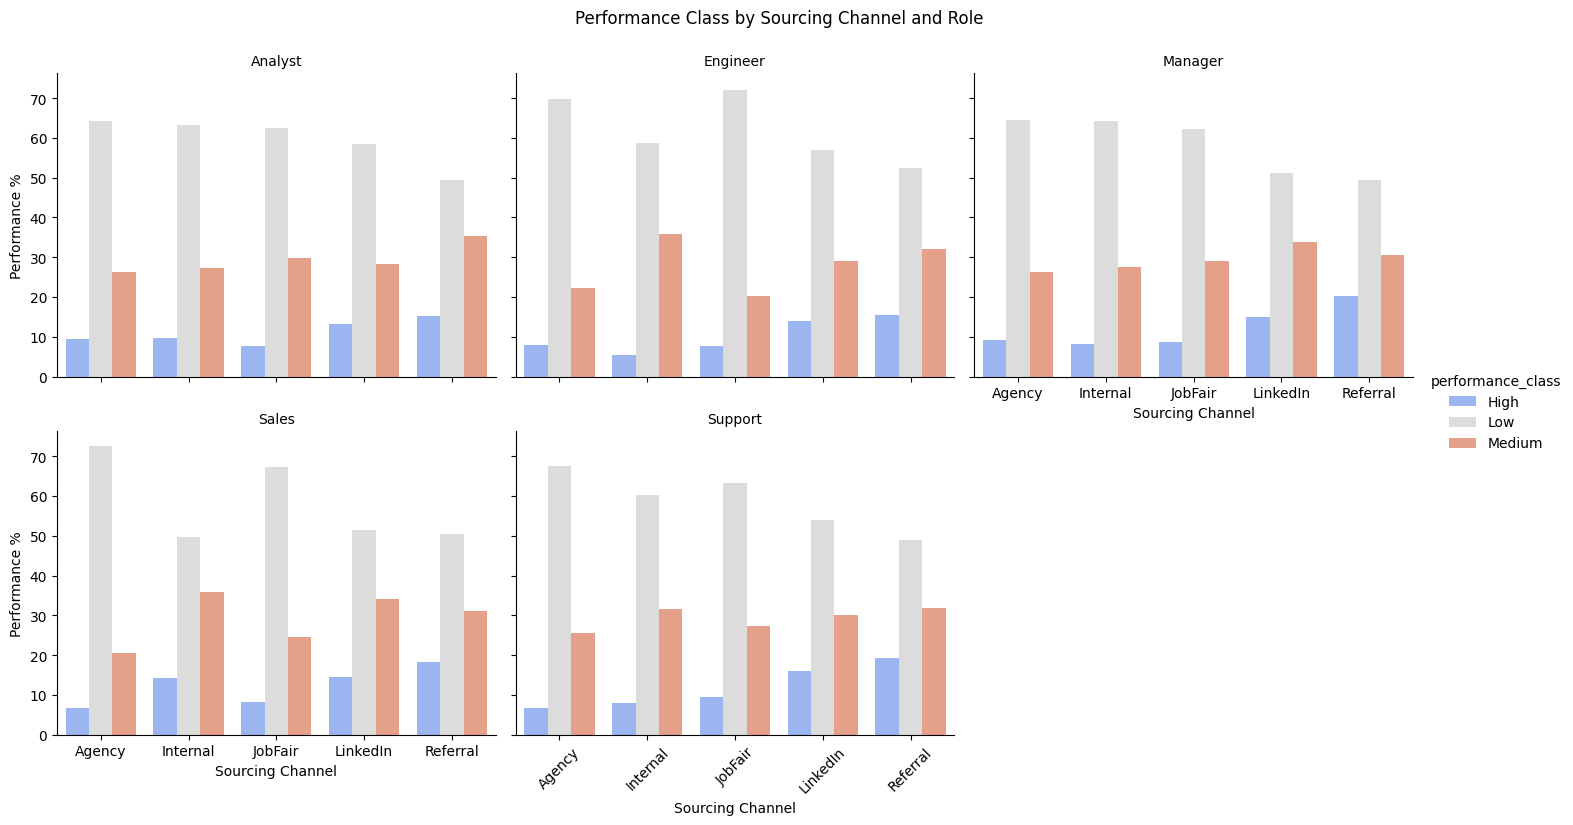

In [38]:
# Group and normalize
role_grouped = df.groupby(['role', 'sourcing_channel', 'performance_class']).size().reset_index(name='count')
role_grouped['percent'] = role_grouped.groupby(['role', 'sourcing_channel'])['count'].transform(lambda x: 100 * x / x.sum())

# Plot
g = sns.catplot(
    data=role_grouped,
    kind="bar",
    x="sourcing_channel", y="percent", hue="performance_class",
    col="role", col_wrap=3,
    height=4, aspect=1.2,
    palette="coolwarm"
)

g.set_titles("{col_name}")
g.set_axis_labels("Sourcing Channel", "Performance %")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Performance Class by Sourcing Channel and Role")
plt.xticks(rotation=45)
plt.show()


In [40]:
# Function to run chi-square test for a given demographic variable
def run_chi_square_by_group(df, group_var):
    results = []
    for group in df[group_var].unique():
        sub_df = df[df[group_var] == group]
        contingency = pd.crosstab(sub_df['sourcing_channel'], sub_df['performance_class'])
        if contingency.shape[0] > 1 and contingency.shape[1] > 1:
            chi2, p, dof, expected = chi2_contingency(contingency)
            results.append({
                group_var: group,
                'Chi-square Statistic': chi2,
                'Degrees of Freedom': dof,
                'p-value': p
            })
    return pd.DataFrame(results)

# Run chi-square tests for Gender, Race, and Role
chi_gender = run_chi_square_by_group(df, 'gender')
chi_race = run_chi_square_by_group(df, 'race')
chi_role = run_chi_square_by_group(df, 'role')

print (chi_gender)
print (chi_race)
print (chi_role)

       gender  Chi-square Statistic  Degrees of Freedom       p-value
0        Male             73.633541                   8  9.257804e-13
1      Female             74.070225                   8  7.571348e-13
2  Non-Binary             57.562409                   8  1.398481e-09
     race  Chi-square Statistic  Degrees of Freedom       p-value
0   Asian             49.477494                   8  5.148997e-08
1   Other             50.091409                   8  3.924742e-08
2   White             43.686219                   8  6.521308e-07
3  Latino             39.576246                   8  3.841691e-06
4   Black             26.860775                   8  7.471993e-04
       role  Chi-square Statistic  Degrees of Freedom       p-value
0  Engineer             54.168187                   8  6.403913e-09
1   Manager             42.778974                   8  9.667477e-07
2     Sales             65.740317                   8  3.444518e-11
3   Analyst             25.294135                   

We tested whether the distribution of performance classes (Low, Medium, High) is significantly different across sourcing channels, within each subgroup (e.g., males vs. females, Engineers vs. Sales, etc.).
* Sourcing Channel × Performance Class across Gender

* Sourcing Channel × Performance Class across Race

* Sourcing Channel × Performance Class across Role

Overall: The p-values for all tests are well below 0.05, meaning:

There is a statistically significant association between sourcing channel and performance class across each gender, race, and role subgroup.

In [41]:
# For males only
male_df = df[df['gender'] == 'Male']
pd.crosstab(male_df['sourcing_channel'], male_df['performance_class'], normalize='index')


performance_class,High,Low,Medium
sourcing_channel,,,
Agency,0.071429,0.640212,0.288360
Internal,0.085635,0.591160,0.323204
JobFair,0.078040,0.624319,0.297641
LinkedIn,0.154286,0.514286,0.331429
Referral,0.200326,0.488599,0.311075


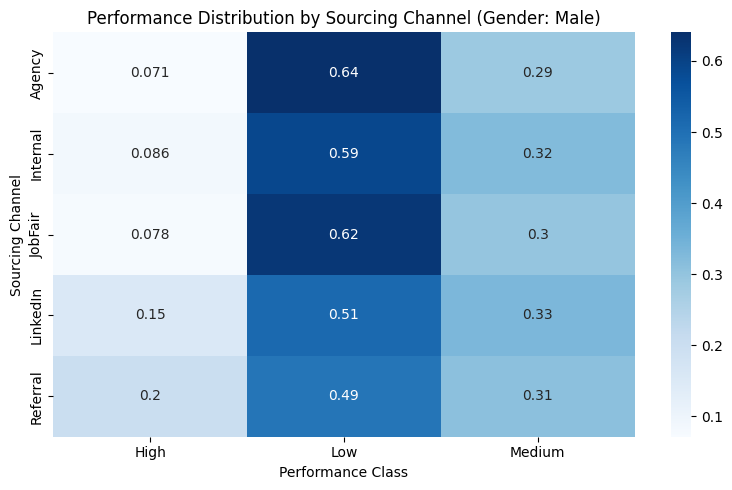

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

subgroups = {
    "Gender": df['gender'].unique(),
    "Race": df['race'].unique(),
    "Role": df['role'].unique()
}

heatmap_data = {}

for group_name, values in subgroups.items():
    for value in values:
        subset = df[df[group_name.lower()] == value]
        crosstab = pd.crosstab(subset['sourcing_channel'], subset['performance_class'], normalize='index')
        heatmap_data[f"{group_name}: {value}"] = crosstab

# Display one heatmap as an example: Gender: male
example = heatmap_data["Gender: Male"]
plt.figure(figsize=(8, 5))
sns.heatmap(example, annot=True, cmap='Blues')
plt.title("Performance Distribution by Sourcing Channel (Gender: Male)")
plt.ylabel("Sourcing Channel")
plt.xlabel("Performance Class")
plt.tight_layout()
plt.show()


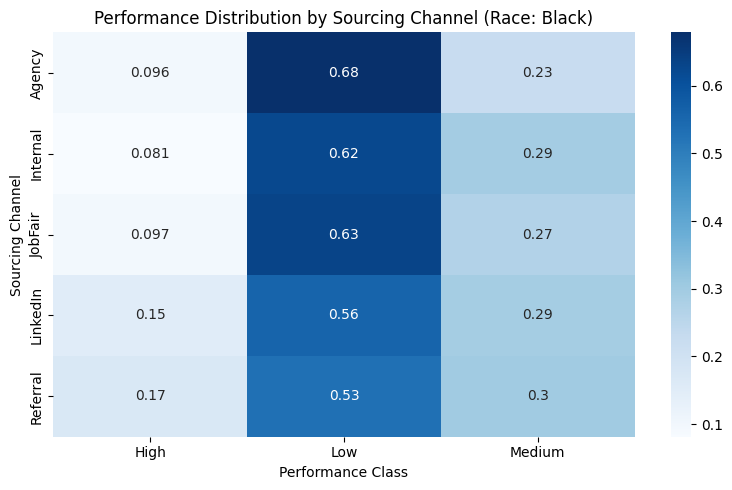

In [44]:

# Display one heatmap as an example: Race: Black
example = heatmap_data["Race: Black"]
plt.figure(figsize=(8, 5))
sns.heatmap(example, annot=True, cmap='Blues')
plt.title("Performance Distribution by Sourcing Channel (Race: Black)")
plt.ylabel("Sourcing Channel")
plt.xlabel("Performance Class")
plt.tight_layout()
plt.show()

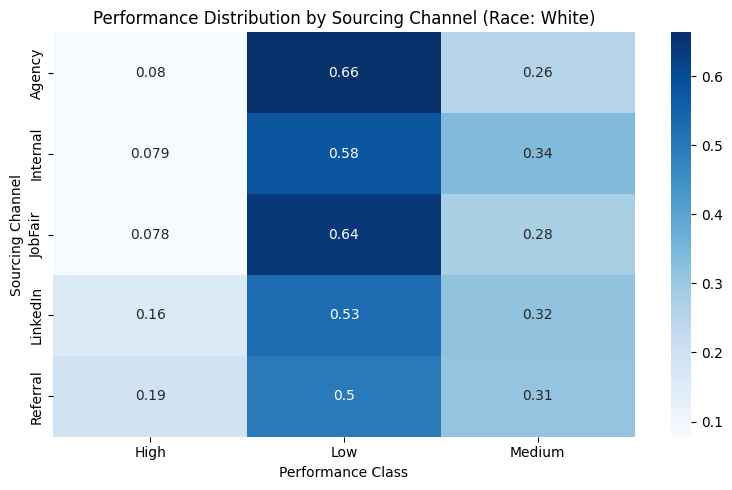

In [45]:
# Display one heatmap as an example: Race: White
example = heatmap_data["Race: White"]
plt.figure(figsize=(8, 5))
sns.heatmap(example, annot=True, cmap='Blues')
plt.title("Performance Distribution by Sourcing Channel (Race: White)")
plt.ylabel("Sourcing Channel")
plt.xlabel("Performance Class")
plt.tight_layout()
plt.show()

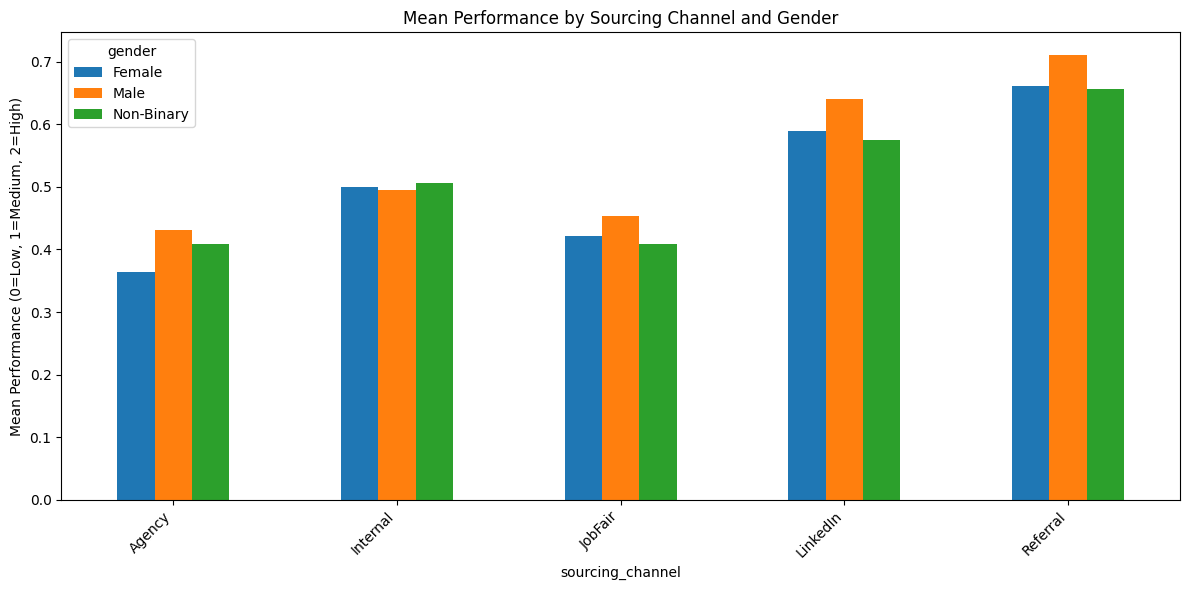

In [48]:
# Map performance classes to numerical values
performance_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['performance_numeric'] = df['performance_class'].map(performance_mapping)

# Calculate the mean performance by sourcing channel and gender
mean_performance_by_channel_gender = df.groupby(['sourcing_channel', 'gender'])['performance_numeric'].mean().unstack()

# Plot the mean performance
mean_performance_by_channel_gender.plot(kind='bar', figsize=(12, 6))
plt.title("Mean Performance by Sourcing Channel and Gender")
plt.ylabel("Mean Performance (0=Low, 1=Medium, 2=High)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [49]:
from scipy.stats import pointbiserialr

# Create dummy variable for binary performance (1 = High, 0 = otherwise)
df['performance_binary'] = (df['performance_class'] == 'High').astype(int)

# Example: Correlate each channel with performance_binary
for ch in df['sourcing_channel'].unique():
    df[f'channel_{ch}'] = (df['sourcing_channel'] == ch).astype(int)
    corr, pval = pointbiserialr(df[f'channel_{ch}'], df['performance_binary'])
    print(f"{ch}: r = {corr:.3f}, p = {pval:.4e}")


Referral: r = 0.094, p = 4.7632e-17
Agency: r = -0.056, p = 6.0323e-07
Internal: r = -0.038, p = 5.7714e-04
JobFair: r = -0.061, p = 5.0076e-08
LinkedIn: r = 0.040, p = 3.9867e-04


Correlation direction: a sourcing channel is associated with higher or lower odds of producing top performers.

Correlation magnitude (even though small) can still be significant at large sample sizes (e.g., 8000 rows).

Referral stands out as the most effective channel here, followed by LinkedIn.